In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  

# Big Question
Target Value = Residual Load
What values will we get real time?

# Data Transformation

### Reading and Clean the Dataset

In [28]:
# Load dataset and convert 'Date' column to datetime format
df = pd.read_csv('../data/DATASET_final_untransformed_uncleaned.csv', sep=";")
df["Date"] = pd.to_datetime(df["Date"])

# Keep only the data from June 1, 2018, onwards, as the global radiation dataset starts from this date (reported by Celine)
df = df[df["Date"] >= '2018-06-18']

# Set 'Date' as the index for time-based operations
df.set_index("Date", inplace=True)

# Define valid value ranges for data cleaning
valid_ranges = {
    'Air_Temperature': (-90, 60),
    'Relative_Humidity': (0, 100),
    'Visibility': (0, 10),
    'Air_Pressure_at_Station_Height': (870, 1085),
    'Cloud_Cover': (0, 8),
    'Daily_Precipitation_Height': (0, np.inf),
    'Snow_Height_Daily_Value': (0, np.inf),
    'Global_Radiation': (0.1, np.inf),
    'Vapor_Pressure': (0, 70),
    'Dew_Point_Temperature': (-80, 30),
    'Wind_Direction': (0, 31),
    'Wind_Strength': (0, 12),
}

def clean_column(x, col_name):
    """Replace values outside the valid range with NaN."""
    min_val, max_val = valid_ranges.get(col_name, (None, None))
    return x.where((x >= min_val) & (x <= max_val), np.nan) if min_val is not None else x

# Apply cleaning function to all columns
for col in df.columns:
    df[col] = clean_column(df[col], col)

### Imputing Missing Values

In [29]:
from sklearn.experimental import enable_iterative_imputer  # This is necessary to enable IterativeImputer
from sklearn.impute import IterativeImputer

missing_before = df.isna().sum()

# Initialize IterativeImputer (MICE method)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values and convert back to DataFrame with original columns
df_imputed = pd.DataFrame(imputer.fit_transform(df), 
                                               columns=df.columns)

# Clip negative values to 0 for all columns after imputation, except 'Dew_Point_Temperature' and 'Air_Temperature', 
# as these columns can validly contain negative values (e.g., for temperatures below freezing).
columns_to_clip = df_imputed.columns.difference(['Dew_Point_Temperature', 'Air_Temperature'])

# Apply clipping for all columns except the ones in the exclusion list
df_imputed[columns_to_clip] = df_imputed[columns_to_clip].clip(lower=0)

# Restore the original index and update the original dataframe
df_imputed.index = df.index

missing_after = df_imputed.isna().sum()

# Output the before and after missing values for each column
missing_values_comparison = pd.DataFrame({
    'Before Imputation': missing_before,
    'After Imputation': missing_after
})

print(missing_values_comparison)

                                                   Before Imputation  \
Total (grid load) [MWh] Calculated resolutions                     0   
Residual load [MWh] Calculated resolutions                         0   
Hydro pumped storage [MWh] Calculated resolutions                  0   
Air_Temperature                                                   23   
Relative_Humidity                                                 23   
Visibility                                                        23   
Air_Pressure_at_Station_Height                                    19   
Cloud_Cover                                                       65   
Daily_Precipitation_Height                                         1   
Snow_Height_Daily_Value                                          558   
Global_Radiation                                                 287   
Vapor_Pressure                                                    23   
Dew_Point_Temperature                                           

# Exploratory Data Analysis

### Data Visualization

In [30]:
# # Set up the figure and axes
# num_columns = len(df_imputed.columns)
# fig, axes = plt.subplots(num_columns, 1, figsize=(num_columns, num_columns*1.5))  # Adjust figsize as needed

# # Define a color palette (you can adjust the palette)
# palette = sns.color_palette("dark", n_colors=num_columns)

# # Loop through each column and plot it in the corresponding subplot with a different color
# for i, column in enumerate(df_imputed.columns):
#     sns.lineplot(data=df_imputed, x=df_imputed.index, y=column, ax=axes[i], color=palette[i])
#     axes[i].set_title(column)
#     axes[i].set_xlabel('Date')
#     axes[i].set_ylabel('Value')
#     axes[i].grid(True)

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the plots
# plt.show()

In [31]:
# # Set Date as the index for correlation
# scale = 8
# # Create a correlation matrix
# corr_matrix = df_imputed.corr()
# plt.figure(figsize=(2*scale, 1*scale))
# # Create a heatmap to visualize the correlation matrix
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
#             fmt=".2f", linewidths=0.5)

# # Show the plot
# plt.title('Correlation Heatmap')
# plt.show()

In [32]:
# import matplotlib.pyplot as plt

# # Define the periods you want to plot
# periods = [
#     ("2018-12", "2019-01"),
#     ("2019-12", "2020-01"),
#     ("2020-12", "2021-01"),
#     ("2021-12", "2022-01"),
#     ("2022-12", "2023-01"),
#     ("2023-12", "2024-01"),
#     ("2024-12", "2025-01")
# ]

# # Create subplots (7 rows, 1 column, as you have 7 periods)
# fig, ax = plt.subplots(len(periods), 1, figsize=(15, 20))

# # Loop through periods and plot each on a separate subplot
# for i, (start_date, end_date) in enumerate(periods):
#     df['Residual load [MWh] Calculated resolutions'][start_date:end_date].plot(
#         kind='line', ax=ax[i], title=f"Residual Load ({start_date} to {end_date})"
#     )
#     ax[i].set_xlabel("Dates")
#     ax[i].set_ylabel("Residual Load (MWh)")

# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()


# Feature Engineering

### Feature Exploration

In [33]:
# Compute correlation matrix
corr_matrix = df_imputed.corr().abs()  # Use absolute values to check both positive & negative correlation

# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above a threshold (e.g., 0.85)
threshold = 0.85
highly_correlated_pairs = []

for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > threshold:
            highly_correlated_pairs.append((row, col, upper.loc[row, col]))

# Convert to DataFrame for better readability
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
correlated_df = correlated_df.sort_values(by="Correlation", ascending=False)

# Display results
print("Highly Correlated Feature Pairs (Threshold > 0.85):")
display(correlated_df)

Highly Correlated Feature Pairs (Threshold > 0.85):


,Feature 1,Feature 2,Correlation
2,Air_Temperature,Dew_Point_Temperature,0.975497
3,Vapor_Pressure,Dew_Point_Temperature,0.947489
0,Total (grid load) [MWh] Calculated resolutions,Residual load [MWh] Calculated resolutions,0.933237
1,Air_Temperature,Vapor_Pressure,0.872194


### Adding day, month, year, holiday, and some other feature

In [34]:
# Create a new dataframe to store the transformed data
df_transformed = df_imputed.copy()

# Add year, month, and day feature
df_transformed['dayofweek'] = df_transformed.index.dayofweek
df_transformed['quarter'] = df_transformed.index.quarter
df_transformed['month'] = df_transformed.index.month
df_transformed['year'] = df_transformed.index.year
df_transformed['dayofyear'] = df_transformed.index.dayofyear

def check_holiday(date):
    if (date.month == 12 and date.day == 24):  # Weihnachten (Christmas Eve)
        return 'Weihnachten'
    elif (date.month == 12 and date.day == 31):  # Silvester (New Year's Eve)
        return 'Silvester'
    else:
        return 'No_Holiday'

df_transformed['holiday'] = df_transformed.index.to_series().apply(check_holiday)
df_transformed['holiday'] = df_transformed['holiday'].astype("category")

# Removing Dew_Point_Temperature and Vapor_Pressure because of high correlation with air temperature and air temperature correlate more with the residual load
df_transformed = df_transformed.drop(["Dew_Point_Temperature", "Vapor_Pressure"], axis=1)

# Convert wind direction to radians for calculations
df_transformed['Wind_Direction_rad'] = np.deg2rad(df_transformed['Wind_Direction'])

# Calculate u and v components
df_transformed['wind_u'] = df_transformed['Wind_Strength'] * np.sin(df_transformed['Wind_Direction_rad'])
df_transformed['wind_v'] = df_transformed['Wind_Strength'] * np.cos(df_transformed['Wind_Direction_rad'])

# Drop some columns that is not needed
df_transformed = df_transformed.drop(columns=['Wind_Direction_rad', "Wind_Strength", 'Wind_Direction'], axis=1)

# Rename some columns
rename_dict = {
    'Total (grid load) [MWh] Calculated resolutions': 'Total_Load',
    'Residual load [MWh] Calculated resolutions': 'Residual_Load',
    'Hydro pumped storage [MWh] Calculated resolutions': 'Hydro_Pumped_Storage'
}
df_transformed.rename(columns=rename_dict, inplace=True)

### Add Electricity Generation Data to the Dataset

In [35]:
trsnet_generation = pd.read_csv(
    "../data/transnetBW electricity dataset/TransnetBW_electricity_actual_generation_day_150101_250320.csv",
    usecols=['Start date', 'Wind onshore [MWh] Calculated resolutions', 'Photovoltaics [MWh] Calculated resolutions'], delimiter=";",thousands=","  
)
trsnet_generation['Start date'] = pd.to_datetime(trsnet_generation['Start date'], format='%b %d, %Y')
trsnet_generation = trsnet_generation[trsnet_generation['Start date'] <= "2025-02-04"]
trsnet_generation.set_index('Start date', inplace=True)

# Ensure numeric data type for summation
trsnet_generation['Wind onshore [MWh] Calculated resolutions'] = trsnet_generation['Wind onshore [MWh] Calculated resolutions'].str.replace(',', '')
trsnet_generation['Wind onshore [MWh] Calculated resolutions'] = pd.to_numeric(trsnet_generation['Wind onshore [MWh] Calculated resolutions'], errors='coerce')
trsnet_generation['Photovoltaics [MWh] Calculated resolutions'] = trsnet_generation['Photovoltaics [MWh] Calculated resolutions'].str.replace(',', '')
trsnet_generation['Photovoltaics [MWh] Calculated resolutions'] = pd.to_numeric(trsnet_generation['Photovoltaics [MWh] Calculated resolutions'], errors='coerce')

trsnet_generation['Electricity_Generated_Total'] = (
    trsnet_generation['Wind onshore [MWh] Calculated resolutions'] +
    trsnet_generation['Photovoltaics [MWh] Calculated resolutions']
)

trsnet_generation.rename(columns={'Wind onshore [MWh] Calculated resolutions': 'Electricity_Generated_Wind',
                                  'Photovoltaics [MWh] Calculated resolutions': 'Electricity_Generated_Photovoltaics'}, inplace=True)

# trsnet_generation = trsnet_generation[['electricity_generated']]

In [36]:
df_transformed = df_transformed.join(trsnet_generation, how='left')

new_column_order = [
    'Total_Load', 'Residual_Load', 'Electricity_Generated_Total', 'Electricity_Generated_Wind', 'Electricity_Generated_Photovoltaics',   # Electricity-related columns
    'Air_Temperature', 'Relative_Humidity', 'Visibility', 'Air_Pressure_at_Station_Height', 
    'Cloud_Cover', 'Daily_Precipitation_Height', 'Snow_Height_Daily_Value', 'Global_Radiation',  
    'wind_u', 'wind_v',  # Weather-related columns
    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'holiday'  # Temporal features
]

df_transformed = df_transformed[new_column_order]

### Add lag feature

In [37]:
target_map = df_transformed['Residual_Load'].to_dict()
df_transformed['Residual_Load_Tomorrow']= (df_transformed.index + pd.Timedelta(unit='days', value=1)).map(target_map)
df_transformed.dropna(inplace=True)
print(df_transformed.columns)

Index(['Total_Load', 'Residual_Load', 'Electricity_Generated_Total',
       'Electricity_Generated_Wind', 'Electricity_Generated_Photovoltaics',
       'Air_Temperature', 'Relative_Humidity', 'Visibility',
       'Air_Pressure_at_Station_Height', 'Cloud_Cover',
       'Daily_Precipitation_Height', 'Snow_Height_Daily_Value',
       'Global_Radiation', 'wind_u', 'wind_v', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'holiday', 'Residual_Load_Tomorrow'],
      dtype='object')


# Model Training

## Function for Training XGBoost Model

In [38]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

def train_xgboost_model(X, y, enable_categorical=True, n_splits=5, n_estimators=100, learning_rate=0.1, random_state=42):
    """
    Train an XGBoost model with time series cross-validation and evaluate it.
    
    Parameters:
    - X: Features (DataFrame)
    - y: Target variable (Series)
    - enable_categorical: Whether to enable support for categorical features.
    - n_splits: Number of splits for TimeSeriesSplit
    - n_estimators: Number of trees in the XGBoost model
    - learning_rate: Learning rate for the XGBoost model
    - random_state: Random seed for reproducibility
    
    Returns:
    - avg_mae: Average Mean Absolute Error across all folds
    - avg_rmse: Average Root Mean Squared Error across all folds
    - avg_r2: Average R² Score across all folds
    
    """
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Store results
    xgb_mae, xgb_rmse, xgb_r2, xgb_mape = [], [], [], []

    # Cross-validation loop
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train XGBoost model
        xgb_model = XGBRegressor(enable_categorical=enable_categorical,n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
        xgb_model.fit(X_train, y_train)
        xgb_pred = xgb_model.predict(X_test)

        # Evaluate XGBoost
        xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
        xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
        xgb_r2.append(r2_score(y_test, xgb_pred))
        # Calculate MAPE and append
        mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100
        xgb_mape.append(mape)

    # Calculate average scores
    avg_mae = np.mean(xgb_mae)
    avg_rmse = np.mean(xgb_rmse)
    avg_r2 = np.mean(xgb_r2)
    avg_mape = np.mean(xgb_mape)

    # Print average scores
    print("--- XGBoost Cross-Validation Results ---")
    print(f"Avg MAE: {avg_mae:.2f} (in MWh)")
    print(f"Avg RMSE: {avg_rmse:.2f} (in MWh)")
    print(f"Avg R² Score: {avg_r2:.2f}")
    print(f"Avg MAPE: {avg_mape:.2f} %")

    """
    - RMSE (Root Mean Squared Error): Measures how well the model's predictions match the actual values. Lower RMSE is better.
    - MAE (Mean Absolute Error): Gives the average absolute difference between predictions and true values. Like RMSE, lower MAE is better.
    - R² (R-Squared): Indicates how much of the variance in the target variable is explained by the model. Higher R² is better, with 1 being a perfect fit.
    - MAPE (Mean Absolute Percentage Error): Measures prediction accuracy as a percentage of the true values. Lower MAPE is better.
    """
    return avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model


## Function for Plotting

In [81]:
import matplotlib.dates as mdates

# Define the plotting function
def plot_predictions(y_train, y_test, xgb_pred, start_date, end_date):
    # Prepare the dataframes
    y_train_df = pd.DataFrame(y_train).rename(columns={y_train.name: 'y_train'})
    y_test_df = pd.DataFrame(y_test).rename(columns={y_test.name: 'y_test'})
    xgb_pred_df = pd.DataFrame(xgb_pred, index=y_test.index).rename(columns={0: 'xgb_pred'})

    # Merge them all into a single DataFrame
    combined_df = pd.concat([y_train_df, y_test_df, xgb_pred_df], axis=1)
    filtered_df = combined_df.loc[start_date:end_date]

    # Plotting the combined DataFrame
    plt.figure(figsize=(25, 5))

    plt.plot(filtered_df.index, filtered_df['y_train'], label='Actual (Train Data)', color='grey')
    plt.plot(filtered_df.index, filtered_df['y_test'], label='Actual (Test Data)', color='blue')
    plt.plot(filtered_df.index, filtered_df['xgb_pred'], label='Predicted (XGBoost)', color='green')


    plt.title('True vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Residual Load')

    # # Format the x-axis to show daily ticks
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Set major ticks at daily intervals
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date on x-axis

    plt.grid(True)
    plt.legend()

    plt.show()


# Train on Available Features All at Once

In [82]:
# Features and target
X = df_transformed.drop(columns=['Residual_Load_Tomorrow', 'holiday', 'Electricity_Generated_Total'])

y = df_transformed['Residual_Load_Tomorrow']

X

,Total_Load,Residual_Load,Electricity_Generated_Wind,Electricity_Generated_Photovoltaics,Air_Temperature,Relative_Humidity,Visibility,Air_Pressure_at_Station_Height,Cloud_Cover,Daily_Precipitation_Height,Snow_Height_Daily_Value,Global_Radiation,wind_u,wind_v,dayofweek,quarter,month,year,dayofyear
Date,,,,,,,,,,,,,,,,,,,
2018-06-18,176279.75,148797.25,1719.25,25763.25,21.00,57.33,8.33,994.77,7.670000,0.0,0.0000,315.77,0.818031,1.455928,0,2,6,2018,169
2018-06-19,182117.75,153748.50,2115.50,26253.75,22.43,60.00,8.67,996.20,2.670000,0.0,0.0000,327.68,0.938943,1.765895,1,2,6,2018,170
2018-06-20,186243.25,153937.00,963.50,31342.75,24.80,59.00,8.00,992.10,2.939149,0.0,0.0712,347.78,0.851855,1.436400,2,2,6,2018,171
2018-06-21,187066.75,149707.50,10802.75,26556.50,23.13,59.00,8.67,989.93,5.000000,0.0,0.0000,211.29,0.938943,1.765895,3,2,6,2018,172
2018-06-22,177827.25,144102.00,9123.50,24601.75,15.13,52.33,9.00,997.50,2.670000,0.0,0.0000,330.69,1.037595,2.460141,4,2,6,2018,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30,195257.50,173230.25,7802.25,14225.00,5.82,80.25,8.25,987.10,8.000000,2.0,0.0000,35.37,0.716736,1.867161,3,1,1,2025,30
2025-01-31,193140.50,175436.25,4582.25,13122.00,5.00,79.75,8.50,998.38,7.750000,0.0,0.0000,43.61,0.848417,1.530584,4,1,1,2025,31
2025-02-01,157897.25,123080.75,14196.75,20619.75,1.42,80.25,7.75,999.32,4.000000,0.0,0.0000,68.80,0.569744,1.654658,5,1,2,2025,32


In [83]:
# Train, validate the model and extract relevant returned values
avg_mae, avg_rmse, avg_r2, avg_mape, y_train, y_test, xgb_pred, xgb_model = train_xgboost_model(X, y)

--- XGBoost Cross-Validation Results ---
Avg MAE: 9663.81 (in MWh)
Avg RMSE: 12599.91 (in MWh)
Avg R² Score: 0.84
Avg MAPE: 8.16 %


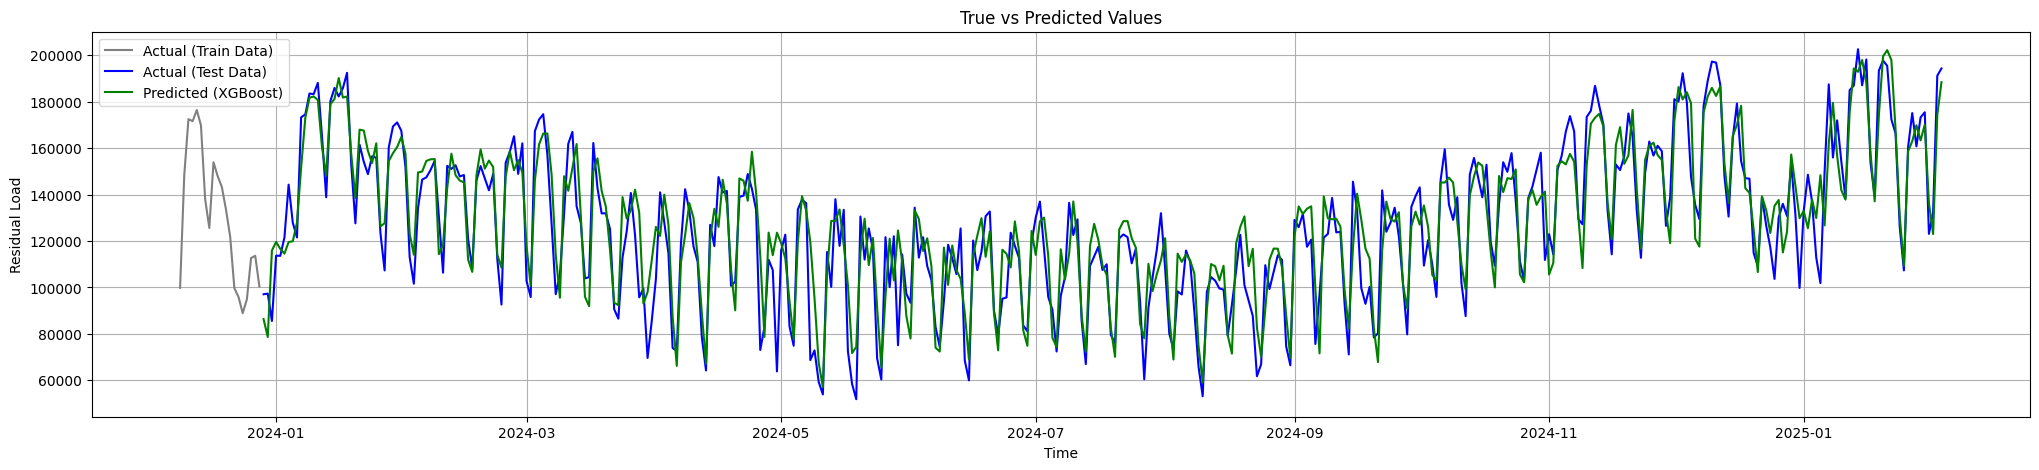

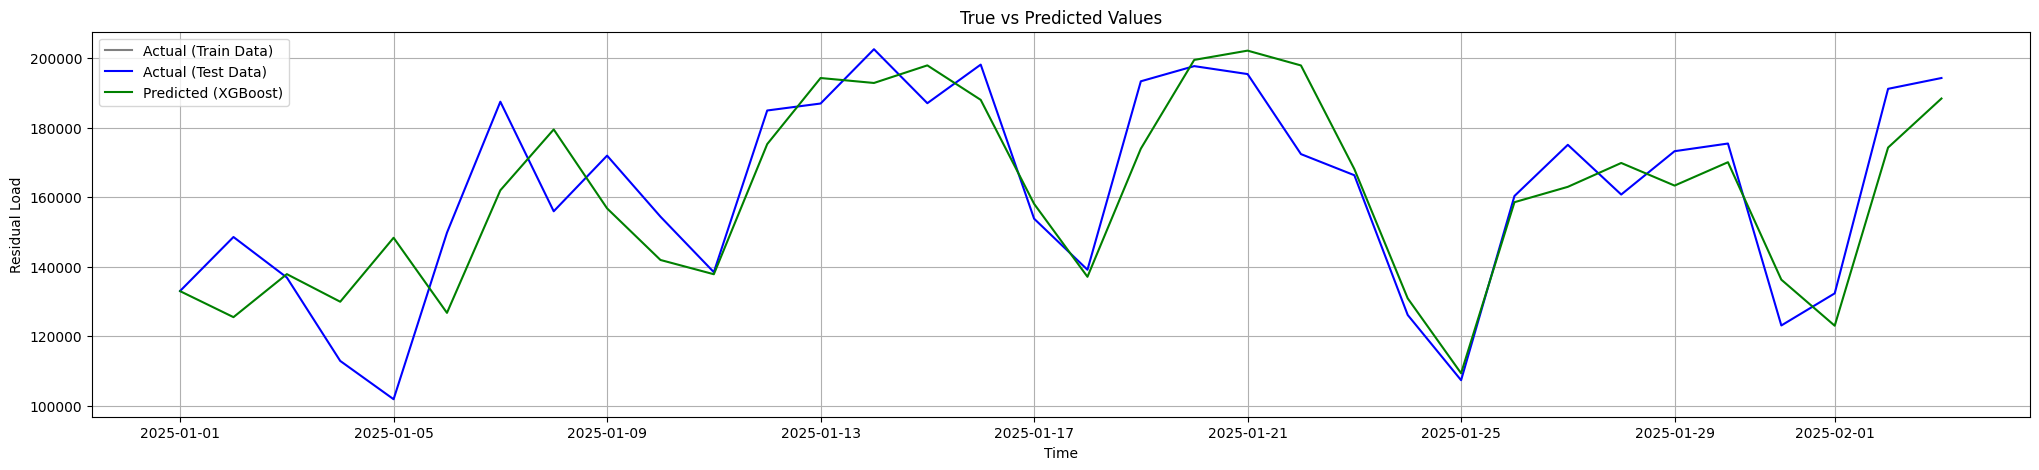

In [96]:
# Plotting prediction results
start_date = y_train.index[-20]
end_date = y_test.index[-1]
plot_predictions(y_train, y_test, xgb_pred, start_date, end_date)

# Plotting prediction results
start_date = "2025-01-01"
end_date = y_test.index[-1]
plot_predictions(y_train, y_test, xgb_pred, start_date, end_date)

### Feature Importance

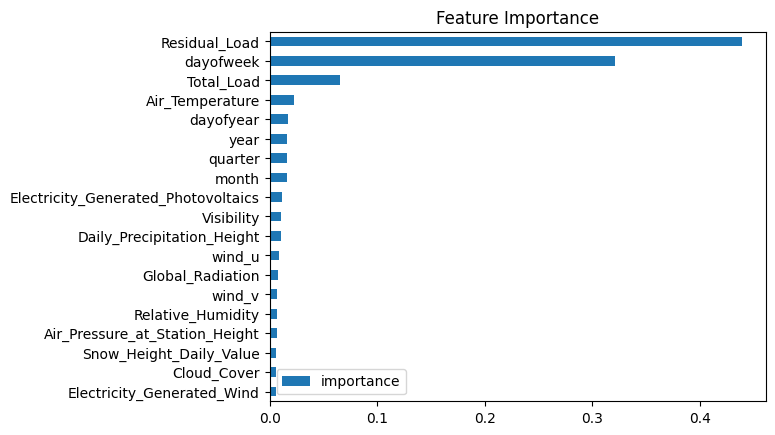

In [85]:
fi = pd.DataFrame(data=xgb_model.feature_importances_, index=xgb_model.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Hyperparameter Tuning

### Best Hyperparameter Values with RandomizedSearch CV

In [86]:
# param_grid = {
#     "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
#     "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
#     "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
#     "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     "subsample": [0.5, 0.7, 1],
#     "colsample_bytree": [0.5, 0.7, 1],
#     "gamma": [0, 0.1, 0.5]
# }

# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# xgb = XGBRegressor(enable_categorical=True)
# random_search = RandomizedSearchCV(
#     xgb, param_grid, cv=5, scoring="neg_mean_squared_error", n_iter=20, n_jobs=-1, random_state=42
# )

# tscv = TimeSeriesSplit(n_splits=5)

# for train_idx, test_idx in tscv.split(X):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
# random_search.fit(X_train, y_train)

# print(random_search.best_params_)

### Best Hyperparameter Values with Bayesian Optimization

In [87]:
# # Bayesian Optimization with additional hyperparamters

# from bayes_opt import BayesianOptimization
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# import numpy as np

# # Define evaluation function
# def xgb_evaluate(learning_rate, max_depth, subsample, colsample_bytree, gamma, min_child_weight, reg_lambda, reg_alpha, n_estimators):
#     params = {
#         "learning_rate": learning_rate,
#         "max_depth": int(max_depth),  # Convert float to int
#         "subsample": subsample,
#         "colsample_bytree": colsample_bytree,
#         "gamma": gamma,  # Ensure gamma is included
#         "min_child_weight": min_child_weight,
#         "reg_lambda": reg_lambda,  # L2 regularization
#         "reg_alpha": reg_alpha,    # L1 regularization
#         "n_estimators": int(n_estimators),  # Convert float to int
#         "objective": "reg:squarederror",
#         "random_state": 42
#     }
    
#     model = xgb.XGBRegressor(**params,enable_categorical=True)

#     # Perform cross-validation and return negative RMSE
#     scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
    
#     return -np.mean(np.sqrt(-scores))  # Negate RMSE for Bayesian Optimization

# # Define parameter bounds
# param_bounds = {
#     "learning_rate": (0.01, 0.3),
#     "max_depth": (3, 15),
#     "subsample": (0.5, 1.0),
#     "colsample_bytree": (0.5, 1.0),
#     "gamma": (0, 10),  # Ensure gamma is included
#     "min_child_weight": (1, 10),
#     "reg_lambda": (0, 10),
#     "reg_alpha": (0, 10),
#     "n_estimators": (100, 1000)
# }

# # Initialize Bayesian Optimizer
# optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)

# # Run optimization
# optimizer.maximize(init_points=10, n_iter=50)

# # Print best parameters
# print("Best parameters:", optimizer.max["params"])

In [88]:
# from bayes_opt import BayesianOptimization
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score
# import numpy as np

# # Define evaluation function
# def xgb_evaluate(learning_rate, max_depth, subsample, colsample_bytree, gamma, min_child_weight, reg_lambda, reg_alpha, n_estimators):
#     params = {
#         "learning_rate": learning_rate,
#         "max_depth": int(max_depth),  # Convert float to int
#         "subsample": subsample,
#         "colsample_bytree": colsample_bytree,
#         "gamma": gamma,  
#         "min_child_weight": min_child_weight,
#         "reg_lambda": reg_lambda,  
#         "reg_alpha": reg_alpha,    
#         "n_estimators": int(n_estimators),  
#         "objective": "reg:squarederror",
#         "random_state": 42,
#         "n_jobs": -1  # Use all CPU cores
#     }
    
#     model = xgb.XGBRegressor(**params, enable_categorical=True)

#     # Perform cross-validation and return negative RMSE
#     scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
    
#     return -np.mean(np.sqrt(-scores))  # Negate RMSE for Bayesian Optimization

# # Define parameter bounds
# param_bounds = {
#     "learning_rate": (0.01, 0.3),
#     "max_depth": (3, 10),  # Reduced upper bound
#     "subsample": (0.5, 1.0),
#     "colsample_bytree": (0.5, 1.0),
#     "gamma": (1e-2, 10),  
#     "min_child_weight": (1, 10),
#     "reg_lambda": (1e-2, 10),
#     "reg_alpha": (1e-2, 10),
#     "n_estimators": (100, 500)  # Reduced upper bound
# }

# # Initialize Bayesian Optimizer
# optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)

# # Run optimization
# optimizer.maximize(init_points=15, n_iter=50)

# # Print best parameters
# print("Best parameters:", optimizer.max["params"])


# Train an XGBoost Model with Time Series Cross-Validation Using Optimized Hyperparameters
This function trains an XGBoost model using time series cross-validation and optimized hyperparameters. It then evaluates its performance across multiple folds.  

In [89]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

def train_xgboost_model_tuned_try(X, y, xgb_params, enable_categorical=True, n_splits=5, random_state=42):
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    if 'n_estimators' in xgb_params:
        xgb_params['n_estimators'] = int(xgb_params['n_estimators'])
    
    if 'max_depth' in xgb_params:
        xgb_params['max_depth'] = int(xgb_params['max_depth'])

    # Store results
    xgb_mae, xgb_rmse, xgb_r2, xgb_mape = [], [], [], []

    # Cross-validation loop
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train XGBoost model
        xgb_model = XGBRegressor(**xgb_params, enable_categorical=enable_categorical, random_state=random_state)
        xgb_model.fit(X_train, y_train)
        xgb_pred = xgb_model.predict(X_test)

        # Evaluate XGBoost
        xgb_mae.append(mean_absolute_error(y_test, xgb_pred))
        xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
        xgb_r2.append(r2_score(y_test, xgb_pred))
        # Calculate MAPE and append
        mape = np.mean(np.abs((y_test - xgb_pred) / y_test)) * 100
        xgb_mape.append(mape)

    # Calculate average scores
    avg_mae = np.mean(xgb_mae)
    avg_rmse = np.mean(xgb_rmse)
    avg_r2 = np.mean(xgb_r2)
    avg_mape = np.mean(xgb_mape)

    # Print average scores
    print("--- XGBoost Cross-Validation Results ---")
    print(f"Avg MAE: {avg_mae:.2f} (in MWh)")
    print(f"Avg RMSE: {avg_rmse:.2f} (in MWh)")
    print(f"Avg R² Score: {avg_r2:.2f}")
    print(f"Avg MAPE: {avg_mape:.2f} %")

    """
    - RMSE (Root Mean Squared Error): Measures how well the model's predictions match the actual values. Lower RMSE is better.
    - MAE (Mean Absolute Error): Gives the average absolute difference between predictions and true values. Like RMSE, lower MAE is better.
    - R² (R-Squared): Indicates how much of the variance in the target variable is explained by the model. Higher R² is better, with 1 being a perfect fit.
    - MAPE (Mean Absolute Percentage Error): Measures prediction accuracy as a percentage of the true values. Lower MAPE is better.
    """
    return X_train, y_train, X_test, y_test, xgb_pred, xgb_model


--- XGBoost Cross-Validation Results ---
Avg MAE: 9044.00 (in MWh)
Avg RMSE: 11927.62 (in MWh)
Avg R² Score: 0.85
Avg MAPE: 7.76 %


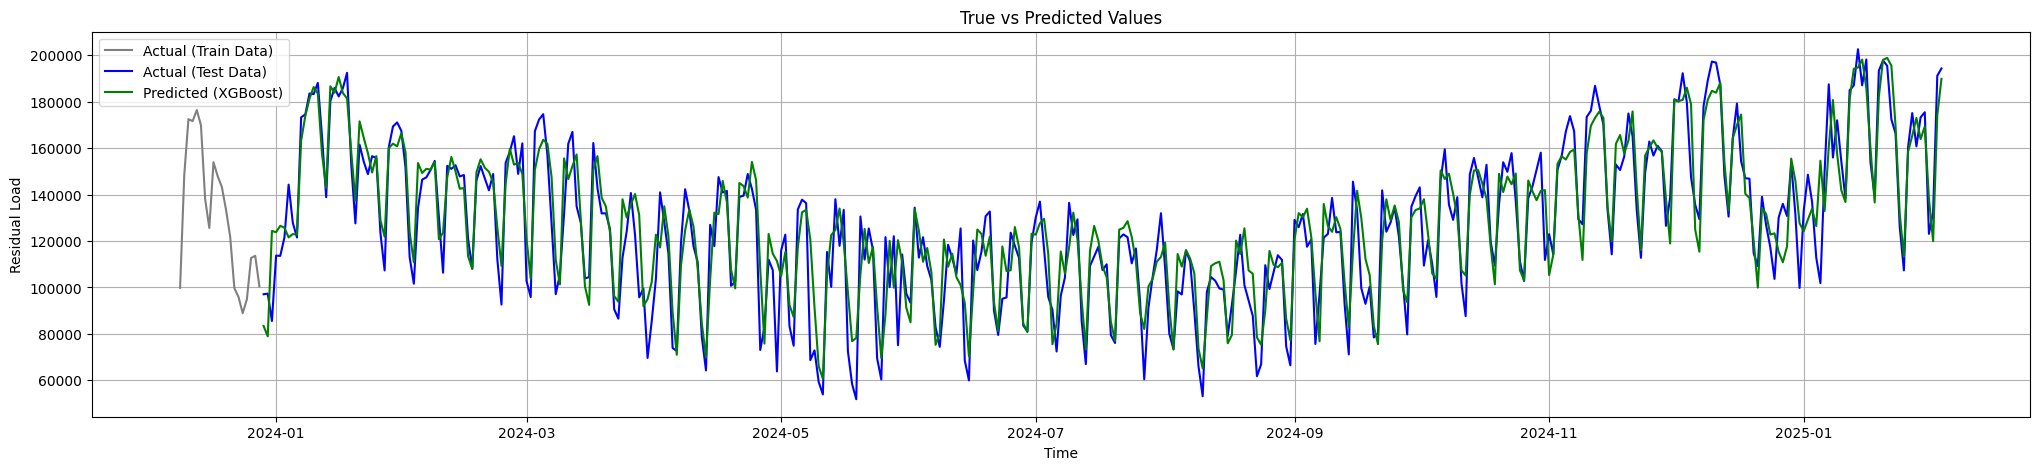

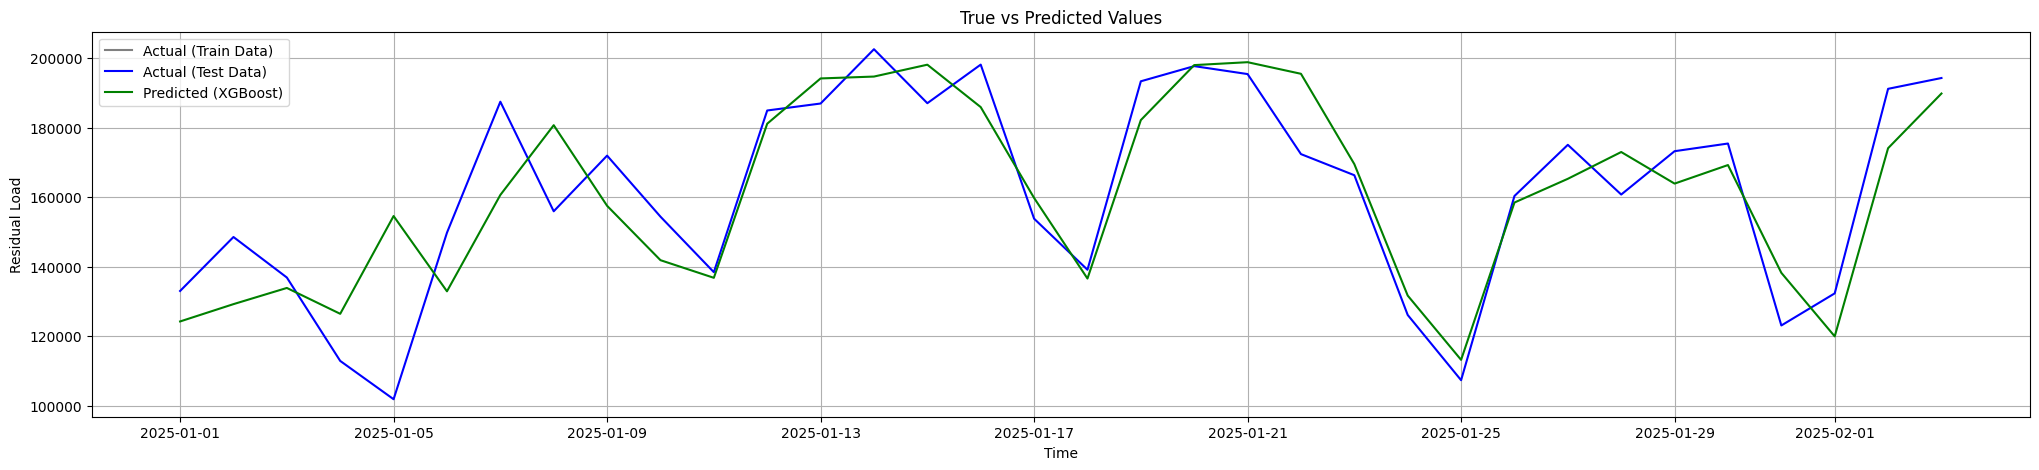

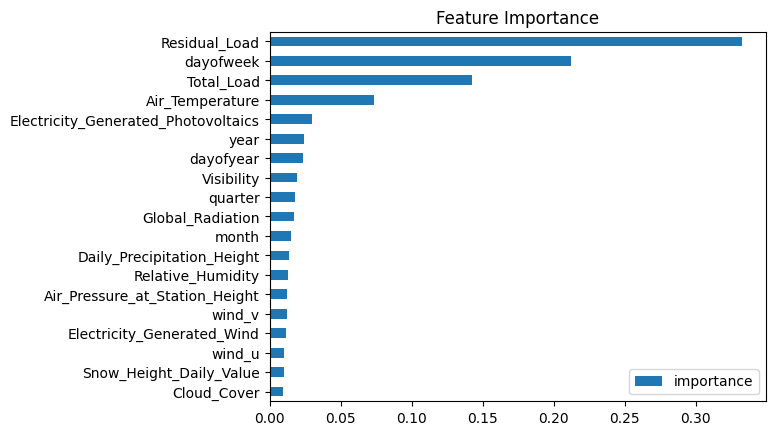

In [95]:
# Best Parameter Found
optimized_hyperparameters_bayesian = {'colsample_bytree': 0.7867153456905416, 'gamma': 7.155511821300545, 'learning_rate': 0.028188361289167817, 'max_depth': 4.669834334593074, 'min_child_weight': 4.054792183825894, 'n_estimators': 397.2499594256708, 'reg_alpha': 7.655858503014215, 'reg_lambda': 1.8279095151502878, 'subsample': 0.5086884187740499}
X_train_tuned, y_train_tuned, X_test_tuned, y_test_tuned, xgb_pred_tuned, xgb_model_tuned = train_xgboost_model_tuned_try(X, y, optimized_hyperparameters_bayesian)

# Plotting prediction results
start_date = y_train_tuned.index[-20]
end_date = y_test_tuned.index[-1]
plot_predictions(y_train_tuned, y_test_tuned, xgb_pred_tuned, start_date, end_date)
# Plotting prediction results
start_date = "2025-01-01"
end_date = y_test_tuned.index[-1]
plot_predictions(y_train_tuned, y_test_tuned, xgb_pred_tuned, start_date, end_date)

fi = pd.DataFrame(data=xgb_model_tuned.feature_importances_, index=xgb_model_tuned.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Exporting trained XGBoost Model

In [91]:
import joblib

# Assuming your trained model is called 'model'
joblib.dump(xgb_model_tuned, "final_xgb_model.pkl")
print("Model saved successfully!")

Model saved successfully!
